In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
rc('animation', html='jshtml')
from sklearn.datasets import make_blobs
matplotlib.rcParams['animation.embed_limit'] = 2**128
from copy import deepcopy


In [2]:
def load_data(n_samples=40,std=None, state = 8):
    if std == None:
        X, y = make_blobs(n_samples=n_samples, n_features=2,centers=2, random_state=state)
    else:
        X, y = make_blobs(n_samples=n_samples, n_features=2,centers=2, random_state=state,cluster_std=std)
    y = y * 2 - 1
    X = np.c_[np.ones(n_samples), X[:, 0], X[:, 1]]
    return X, y

def visualize_kernel_perceptron(X, Y, w, ranges):
    """ Helper function for visualizing decision boundary in input space"""
    fig, ax = plt.subplots(figsize=(6, 6))
    class_1, class_2 = [], []
    for i in range(X.shape[0]):
        if Y[i] == -1:
            class_1.append(X[i])
        else:
            class_2.append(X[i])
    x_range, y_range = ranges[0], ranges[1]
    nsize = 100
    xs = ys = np.linspace(x_range[0],x_range[1], nsize)
    xm, ym = np.meshgrid(xs, ys)
    img = np.zeros((nsize, nsize)) # makes a 100 x 100 2d array
    for i, zy in enumerate(ys):
        for j, zx in enumerate(xs):    
            point = np.array([zx, zy])
            predict = w.dot(point)
            img[i, j] = predict
        
    CS = ax.contour(xs, ys, img, [0], colors='r', linewidths=1)
    CS.collections[0].set_label('Decision boundary')
    ax.plot(np.array(class_1)[:,0],np.array(class_1)[:,1],'o',ms=4,label='Class 1')
    ax.plot(np.array(class_2)[:,0],np.array(class_2)[:,1],'x',ms=4,label='Class 2')

    ax.set_xlim(x_range[0],x_range[1]), ax.set_ylim(y_range[0],y_range[1])
    ax.hlines(0,x_range[0],x_range[1],ls='--',color='k')
    ax.vlines(0,y_range[0],y_range[1],ls='--',color='k')
    ax.set_xlabel('x',size=15), ax.set_ylabel('y',size=15), ax.legend(loc='upper left')
    ax.legend(loc='upper right')
    plt.show()

def get_rbf_kernel(gamma=1):
    assert gamma > 0, 'Gamma must be positive'
    def Kernel(x, z):
        return np.exp((-gamma * np.sum((x-z)**2)))
    return Kernel

class Hyperplane():
    """ Represents a hyperplane H in Feature space that is a linear combination of transformed points from input space
        
        The class can evaluate an input in the original input space mapped to H against the hyperplane        
    """
    def __init__(self, Kernel):
        self.dat    = list()
        self.alpha  = list()
        self.Kernel = Kernel

    def update(self, x, a):
        """ Update hyperplane Representer by point x with weight a i.e. w = w + a * x
        
        Args:
            x: np.array - data point
            a: float - data weight
        """
        self.dat.append(x)
        self.alpha.append(a)

    def dot(self, z):
        """ Compute inner product between hyperplane and z in feature (kernel) space
                
        Args:
            z: np.array
        """
        #out = 0.0
        #for i in range(len(self.dat)):
        #    x, a  = self.dat[i], self.alpha[i]
        #    out += a*self.Kernel(z, x)
        out =  np.sum([a*self.Kernel(z.reshape(1, -1), x) for (x, a) in zip(self.dat, self.alpha)])

        return out
    
class KernelPerceptron():
    
    def __init__(self, kernel):
        self.Kernel          = kernel
        self.hyperplane      = None
        self.score_hist      = None
        self.hyperplane_hist = None

    def fit(self, X, Y, epochs, alpha=0.1):
        """ Kernel Perceptron Algorithm 
            1. Do one pass over the data - for each misprediction (w.dot(x) * y <= 0) add phi(x) with weight y * alpha to hyperplane representation
            
        """
        score_hist, hyperplane_hist = [], []
        hyperplane = Hyperplane(self.Kernel)

        for j in range(epochs):
            n = len(Y)
            for i in range(n):
                x = X[i]
                y = Y[i]
                if hyperplane.dot(x) * y <= 0:
                    hyperplane.update(x, y * alpha)                    
            self.hyperplane = hyperplane

            score_hist.append(self.score(X,Y))
            hyperplane_hist.append(deepcopy(hyperplane))

        self.score_hist      = score_hist
        self.hyperplane_hist = hyperplane_hist
        
    def score(self, X, Y):
        """ Compute Classifier Accuracy
        Args:
          X: np.array n, d
          Y: np.array n, 
        
        Returns:
        out: scalar - accuracy of model on data X with labels Y
        """
        pred = np.sign(np.array([self.hyperplane.dot(x) for x in X]))
        out = (pred == Y).mean()
        return out


[]

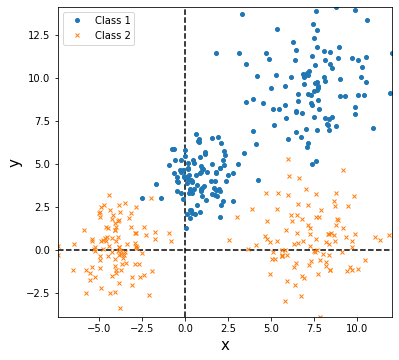

In [3]:
## Creating data and visualizing 
X, y   = load_data(n_samples = 200,state = 3, std = 1.2)
X2, y2 = load_data(n_samples = 200,state = 8, std = 1.8)
data_X, data_y = np.concatenate([X,X2]), np.concatenate([y,y2])

class_1, class_2 = [], []
for i in range(data_X.shape[0]):
    if data_y[i] == -1:
        class_1.append(data_X[i])
    else:
        class_2.append(data_X[i])

x_range = np.linspace(np.min(data_X[:,1]),np.max(data_X[:,1]),100)
y_range = np.linspace(np.min(data_X[:,2]),np.max(data_X[:,2]),100)
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(np.array(class_1)[:,1],np.array(class_1)[:,2],'o',ms=4,label='Class 1')
ax.plot(np.array(class_2)[:,1],np.array(class_2)[:,2],'x',ms=4,label='Class 2')

ax.set_aspect('equal', adjustable='box')
ax.legend(), ax.set_xlim(x_range[0],x_range[-1]), ax.set_ylim(y_range[0],y_range[-1])
ax.hlines(0,x_range[0],x_range[-1],ls='--',color='k'), ax.vlines(0,y_range[0],y_range[-1],ls='--',color='k')
ax.set_xlabel('x',size=15), ax.set_ylabel('y',size=15), ax.legend(loc='upper left')
plt.plot()

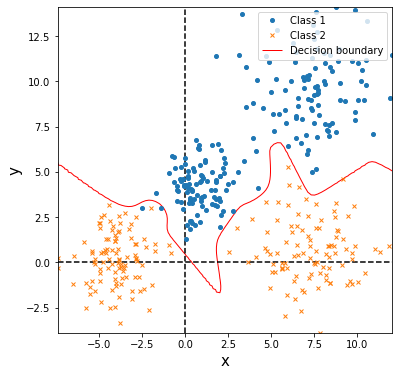

In [5]:
X, Y = data_X[:,[1,2]], data_y
x_range = [np.min(data_X[:,1]),np.max(data_X[:,1])]
y_range = [np.min(data_X[:,2]),np.max(data_X[:,2])]
ranges = [x_range, y_range]

gauss_kernel = get_rbf_kernel(gamma = 1)
classifier = KernelPerceptron(gauss_kernel)
classifier.fit(X, Y,4)
visualize_kernel_perceptron(X, Y, classifier.hyperplane, ranges)

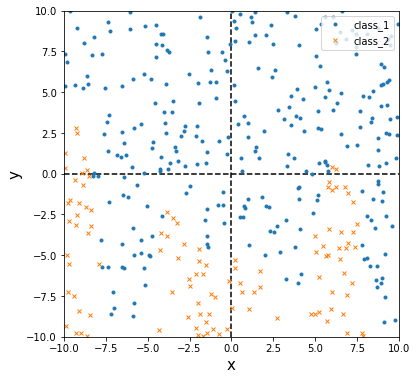

In [6]:
#### Generating new dataset ####

ranges = [-10,10]
def func_lim(x):
    #return x**3*np.cos(x)/100
    return np.float64(x*np.cos(x))
    #return x

def rand_blobs(nr_blobs,lim_func,ranges):
    lower_lim, upper_lim = ranges[0],ranges[1]
    xs = np.float64(np.random.uniform(lower_lim,upper_lim,nr_blobs))
    ys = np.float64(np.random.uniform(lower_lim,upper_lim,nr_blobs))
    class_1, class_2 = [], []
    for i in range(nr_blobs):
        point = np.array([xs[i],ys[i]])
        if func_lim(point[0]) <= point[1]+5:
            class_1.append(point)
        else:
            class_2.append(point)
    return np.array(class_1), np.array(class_2)

class_1, class_2 = rand_blobs(400,func_lim,ranges)

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(class_1[:,0],class_1[:,1],'o',ms = 3,label='class_1')
ax.plot(class_2[:,0],class_2[:,1],'x',ms = 4,label='class_2')
ax.hlines(0,ranges[0],ranges[1],ls='--',color='k')
ax.vlines(0,ranges[0],ranges[1],ls='--',color='k')
ax.set_xlabel('x',size=15), ax.set_ylabel('y',size=15)
ax.set_xlim(ranges[0],ranges[1]), ax.set_ylim(ranges[0],ranges[1])
ax.legend(loc='upper right')
plt.show()


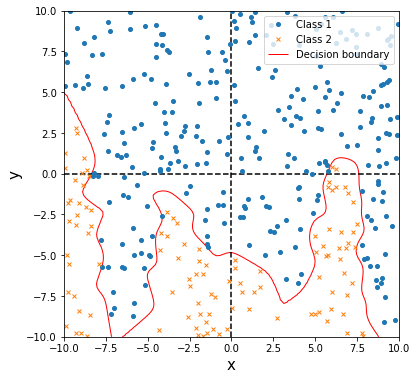

In [9]:
X, Y = np.concatenate([class_1, class_2]), np.concatenate([-np.ones(len(class_1)),np.ones(len(class_2))])
ranges = [[-10,10],[-10,10]]
gauss_kernel = get_rbf_kernel(gamma = 1)
classifier = KernelPerceptron(kernel = gauss_kernel)
classifier.fit(X = X, Y = Y, epochs=6)
visualize_kernel_perceptron(X, Y, classifier.hyperplane, ranges)

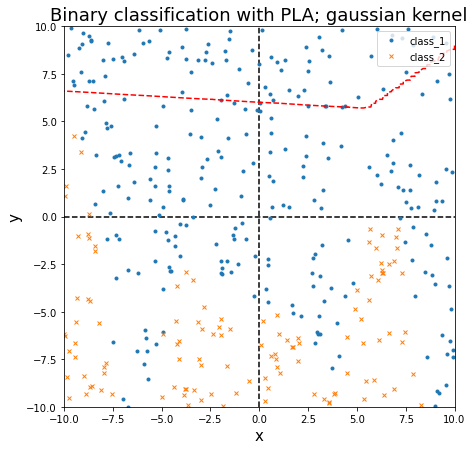

In [212]:
def decision_boundary(n_size,hyperplane,ranges):
    xs = ys = np.linspace(ranges[0],ranges[1], n_size)
    xm, ym = np.meshgrid(xs, ys)
    img = np.zeros((n_size, n_size))
    for i, zy in enumerate(ys):
        for j, zx in enumerate(xs):    
            point = np.array([zx, zy])
            predict = hyperplane.dot(point)
            img[i, j] = predict
    cs = ax.contour(xs, ys, img, [0], colors='r', linewidths=1)
    p = cs.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    return x, y 

xs, ys = [], []
for i in range(len(classifier.score_hist)):
    x, y = decision_boundary(100,classifier.hyperplane_hist[i],[-10,10])
    xs.append(x), ys.append(y)

ranges = [-10,10]

###### Animating ####### 

fig, ax = plt.subplots(1,1,figsize = (7,7))
ax.set_title('Binary classification with PLA; gaussian kernel',size=18)

ax.plot(class_1[:,0],class_1[:,1],'o',ms = 3,label='class_1')
ax.plot(class_2[:,0],class_2[:,1],'x',ms = 4,label='class_2')

ax.hlines(0,ranges[0],ranges[1],ls='--',color='k')
ax.vlines(0,ranges[0],ranges[1],ls='--',color='k')
ax.set_xlabel('x',size=15), ax.set_ylabel('y',size=15)
ax.set_xlim(ranges[0],ranges[1]), ax.set_ylim(ranges[0],ranges[1])
ax.legend(loc='upper right')

prediction, = ax.plot([],[],'--',color='r',label='ith prediction')    

#iteration_text = ax.text(x=-2.55,y=15.0,s='',fontsize=12)


def update(i):
    prediction.set_data(xs[i],ys[i])
    #iteration_text.set_text(i+1)
    return prediction,


anim = animation.FuncAnimation(fig,
                               update,
                               frames=len(classifier.score_hist),
                               interval=500,
                               blit = True,
                               repeat = False)

## uncomment below to save gif ##
#writergif = animation.PillowWriter(fps=3,) 
#anim.save("Binary classification; PLA training_long.gif", writer=writergif)

anim

In [58]:
def decision_boundary(n_size,hyperplane,ranges):
    target_val  = 0.0
    machine_eps = np.finfo(float).eps
    x = y = np.linspace(ranges[0],ranges[1], n_size)
    X, Y = np.meshgrid(x,y)
    x_plot, y_plot = [],[]
    for i in range(n_size):
        for j in range(n_size):
            predict = hyperplane.dot(np.array([x[i],y[j]]))
            if predict == 0.0:
                x_plot.append(Y[i,j])
                y_plot.append(X[i,j])
            
    return np.array(x_plot), np.array(y_plot)

x,y= decision_boundary(200,classifier.hyperplane_hist[-1],[-10,10])
len(x)

0

(-10.0, 10.0)

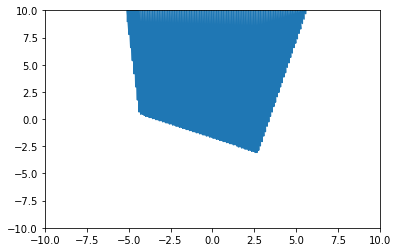

In [57]:
plt.plot(x,y)
plt.xlim(-10,10)
plt.ylim(-10,10)

In [23]:
nr = 100
xs = ys = np.linspace(-10,10, nr)
xm, ym = np.meshgrid(xs, ys)
img = np.zeros((nr, nr))
for i, zy in enumerate(ys):
    for j, zx in enumerate(xs):    
        point = np.array([zx, zy])
        predict = classifier.hyperplane.dot(point)
        img[i, j] = predict

In [133]:
x = np.linspace(1,5,500)
y = np.linspace(-2,2,500)
#x,y 

In [134]:
X,Y = np.meshgrid(x,y)
#X,Y

In [135]:
Z = X**2+Y**2
#Z

(-2.0, 2.0)

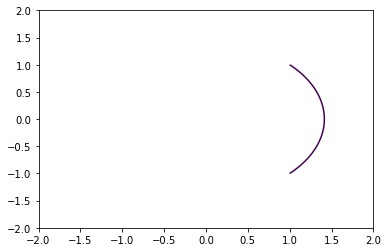

In [143]:
cs = plt.contour(X,Y,Z,levels=[2.00])
plt.xlim(-2,2)
plt.ylim(-2,2)

In [145]:
eps = 0.001
val = 2.0
xs, ys = [],[]
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        if Z[i,j] >= 2.0-eps and Z[i,j] <= 2.0+eps: 
            xs.append(X[i,j])
            ys.append(Y[i,j])
#print(xs,ys)

(-2.0, 2.0)

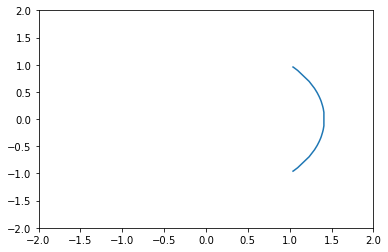

In [146]:
plt.plot(xs,ys)
plt.xlim(-2,2)
plt.ylim(-2,2)

SyntaxError: invalid syntax (4010033748.py, line 1)